# FluVaccine task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from flu_vaccine import FluVaccine
from dataset_generator import DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Error test (low complexity)

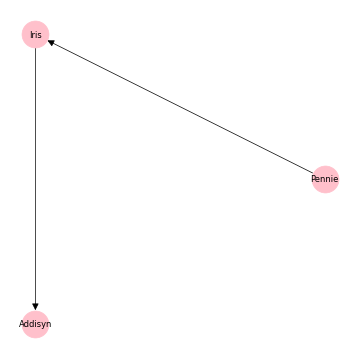


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Pennie will get vaccinated if she had a high fever or bronchitis for at least 7 days in the previous flu season. Iris will get vaccinated if she had a high fever or bronchitis for at least 6 days in the previous flu season or if Pennie gets vaccinated. Addisyn will get vaccinated if she had a high fever or bronchitis for at least 7 days in the previous flu season or if Iris gets vaccinated. 

Sample context:  During the previous flu season, Pennie had a runny nose for 7 days, a cough for 7 days, a low-grade fever for 1 days, stomach pain for 6 days, bronchitis for 8 days, and a high fever for 7 days. Iris had a high fever for 3 days, a cough for 3 days, a runny nose for 7 days, stomach pain for 3 days, bronchitis for 4 days, and a low-grade fever for 3 days. Addisyn had a runny nose for 6 days, a low-grade fever for 1 days, stomach pain for 8 days, a cough for 7 days, bronchit

In [3]:
size = [2,2]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

In [4]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'Addisyn': {'Prompt': 'Did Addisyn get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Pennie': 1, 'Iris': 1, 'Addisyn': 1},
  'True exogenous': {'PDHS': 1, '63DO': 0, 'J02O': 1},
  'True response': 1},
 'Iris': {'Prompt': 'Did Iris get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Pennie': 1, 'Iris': 1, 'Addisyn': 1},
  'True exogenous': {'PDHS': 1, '63DO': 0, 'J02O': 1},
  'True response': 1}}

In [5]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('Pennie', 'Addisyn') --
Prompt: Now, suppose that Pennie got vaccinated regardless of all other circumstances. With this new assumption, did Addisyn get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Pennie': 1, 'Iris': 1, 'Addisyn': 1}
True exogenous: {'PDHS': 1, '63DO': 0, 'J02O': 1}
True response: 1

-----------------------

-- ('Pennie', 'Iris') --
Prompt: Now, suppose that Pennie got vaccinated regardless of all other circumstances. With this new assumption, did Iris get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Pennie': 1, 'Iris': 1, 'Addisyn': 1}
True exogenous: {'PDHS': 1, '63DO': 0, 'J02O': 1}
True response: 1

-----------------------

-- ('Iris', 'Addisyn') --
Prompt: Now, suppose that Iris got vaccinated regardless of all other circumstances. With this new assumption, did Addisyn get vaccinated? Begin 

In [6]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('Pennie', 'Addisyn') --
Prompt: Now, suppose that Pennie did not get vaccinated regardless of all other circumstances. With this new assumption, did Addisyn get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Pennie': 0, 'Iris': 0, 'Addisyn': 1}
True exogenous: {'PDHS': 1, '63DO': 0, 'J02O': 1}
True response: 1

-----------------------

-- ('Pennie', 'Iris') --
Prompt: Now, suppose that Pennie did not get vaccinated regardless of all other circumstances. With this new assumption, did Iris get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Pennie': 0, 'Iris': 0, 'Addisyn': 1}
True exogenous: {'PDHS': 1, '63DO': 0, 'J02O': 1}
True response: 0

-----------------------

-- ('Iris', 'Addisyn') --
Prompt: Now, suppose that Iris did not get vaccinated regardless of all other circumstances. With this new assumption, did Addis

In [7]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,Pennie,Iris,Addisyn
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,PDHS,63DO,J02O
0,1,1,1
1,1,0,0
2,1,0,1
3,1,1,0
4,1,1,1


In [8]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Pennie = 1 --


,Pennie,Iris,Addisyn
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,PDHS,63DO,J02O
0,1,1,1
1,1,0,0
2,1,0,1
3,1,1,0
4,1,1,1



-- Iris = 1 --


,Pennie,Iris,Addisyn
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,PDHS,63DO,J02O
0,1,1,1
1,1,0,0
2,1,0,1
3,1,1,0
4,1,1,1


In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Pennie = 0 --


,Pennie,Iris,Addisyn
0,0,1,1
1,0,0,0
2,0,0,1
3,0,1,1
4,0,1,1


,PDHS,63DO,J02O
0,1,1,1
1,1,0,0
2,1,0,1
3,1,1,0
4,1,1,1



-- Iris = 0 --


,Pennie,Iris,Addisyn
0,1,0,1
1,1,0,0
2,1,0,1
3,1,0,0
4,1,0,1


,PDHS,63DO,J02O
0,1,1,1
1,1,0,0
2,1,0,1
3,1,1,0
4,1,1,1


## Error test (moderate complexity)

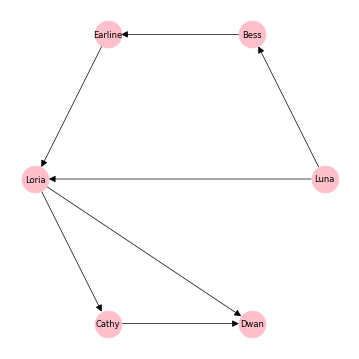


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Luna will get vaccinated if she had a high fever or bronchitis for at least 5 days in the previous flu season. Bess will get vaccinated if she had a high fever or bronchitis for at least 4 days in the previous flu season or if Luna gets vaccinated. Earline will get vaccinated if she had a high fever or bronchitis for at least 8 days in the previous flu season and Bess gets vaccinated. Loria will get vaccinated if she had a high fever or bronchitis for at least 5 days in the previous flu season and Luna gets vaccinated and Earline gets vaccinated. Cathy will get vaccinated if she had a high fever or bronchitis for at least 5 days in the previous flu season or if Loria gets vaccinated. Dwan will get vaccinated if she had a high fever or bronchitis for at least 7 days in the previous flu season or if Loria gets vaccinated or if Cathy gets vaccinated. 

Sample context:  During the

In [10]:
size = [4,3]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

In [11]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'Dwan': {'Prompt': 'Did Dwan get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Luna': 1,
   'Bess': 1,
   'Earline': 1,
   'Loria': 0,
   'Cathy': 0,
   'Dwan': 0},
  'True exogenous': {'OU03': 1,
   'EIUB': 0,
   'YB2X': 1,
   'VCR3': 0,
   'BQW2': 0,
   'E9NZ': 0},
  'True response': 0},
 'Loria': {'Prompt': 'Did Loria get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Luna': 1,
   'Bess': 1,
   'Earline': 1,
   'Loria': 0,
   'Cathy': 0,
   'Dwan': 0},
  'True exogenous': {'OU03': 1,
   'EIUB': 0,
   'YB2X': 1,
   'VCR3': 0,
   'BQW2': 0,
   'E9NZ': 0},
  'True response': 0}}

In [12]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('Luna', 'Dwan') --
Prompt: Now, suppose that Luna got vaccinated regardless of all other circumstances. With this new assumption, did Dwan get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Luna': 1, 'Bess': 1, 'Earline': 1, 'Loria': 0, 'Cathy': 0, 'Dwan': 0}
True exogenous: {'OU03': 1, 'EIUB': 0, 'YB2X': 1, 'VCR3': 0, 'BQW2': 0, 'E9NZ': 0}
True response: 0

-----------------------

-- ('Luna', 'Loria') --
Prompt: Now, suppose that Luna got vaccinated regardless of all other circumstances. With this new assumption, did Loria get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Luna': 1, 'Bess': 1, 'Earline': 1, 'Loria': 0, 'Cathy': 0, 'Dwan': 0}
True exogenous: {'OU03': 1, 'EIUB': 0, 'YB2X': 1, 'VCR3': 0, 'BQW2': 0, 'E9NZ': 0}
True response: 0

-----------------------

-- ('Loria', 'Dwan') --
Prompt: Now, suppose that L

In [13]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('Luna', 'Dwan') --
Prompt: Now, suppose that Luna did not get vaccinated regardless of all other circumstances. With this new assumption, did Dwan get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Luna': 0, 'Bess': 0, 'Earline': 0, 'Loria': 0, 'Cathy': 0, 'Dwan': 0}
True exogenous: {'OU03': 1, 'EIUB': 0, 'YB2X': 1, 'VCR3': 0, 'BQW2': 0, 'E9NZ': 0}
True response: 0

-----------------------

-- ('Luna', 'Loria') --
Prompt: Now, suppose that Luna did not get vaccinated regardless of all other circumstances. With this new assumption, did Loria get vaccinated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Luna': 0, 'Bess': 0, 'Earline': 0, 'Loria': 0, 'Cathy': 0, 'Dwan': 0}
True exogenous: {'OU03': 1, 'EIUB': 0, 'YB2X': 1, 'VCR3': 0, 'BQW2': 0, 'E9NZ': 0}
True response: 0

-----------------------

-- ('Loria', 'Dwan') --
Prompt: No

In [14]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,Luna,Bess,Earline,Loria,Cathy,Dwan
0,1,1,1,1,1,1
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


,OU03,EIUB,YB2X,VCR3,BQW2,E9NZ
0,1,0,1,1,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,1,0,1
4,0,0,1,1,0,1


In [15]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Luna = 1 --


,Luna,Bess,Earline,Loria,Cathy,Dwan
0,1,1,1,1,1,1
1,1,1,1,0,0,0
2,1,1,1,0,1,1
3,1,1,0,0,0,1
4,1,1,1,1,1,1


,OU03,EIUB,YB2X,VCR3,BQW2,E9NZ
0,1,0,1,1,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,1,0,1
4,0,0,1,1,0,1



-- Loria = 1 --


,Luna,Bess,Earline,Loria,Cathy,Dwan
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,0,1,1,1,1,1
3,0,0,0,1,1,1
4,0,0,0,1,1,1


,OU03,EIUB,YB2X,VCR3,BQW2,E9NZ
0,1,0,1,1,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,1,0,1
4,0,0,1,1,0,1


In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Luna = 0 --


,Luna,Bess,Earline,Loria,Cathy,Dwan
0,0,0,0,0,0,0
1,0,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


,OU03,EIUB,YB2X,VCR3,BQW2,E9NZ
0,1,0,1,1,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,1,0,1
4,0,0,1,1,0,1



-- Loria = 0 --


,Luna,Bess,Earline,Loria,Cathy,Dwan
0,1,1,1,0,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


,OU03,EIUB,YB2X,VCR3,BQW2,E9NZ
0,1,0,1,1,0,0
1,1,1,1,0,0,0
2,0,1,1,0,1,1
3,0,0,0,1,0,1
4,0,0,1,1,0,1


In [17]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('Luna', 'Dwan')]
[('Luna', 'Loria'), ('Loria', 'Dwan')]
[[('Luna', 'Loria'), ('Loria', 'Dwan')]]


In [18]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = dg.get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,0
1,1,1,1,0,0,0,0
2,1,1,1,0,1,1,1
3,1,1,0,0,0,1,1
4,1,1,1,1,1,1,1



-- ('Luna', 'Dwan') | n = 5 --
-- PNS = 0.2 | ATE = 0.20000000000000007 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,1,1,1,0
1,1,1,1,0,0,0,0
2,1,1,1,0,1,1,0
3,1,1,0,0,0,1,0
4,1,1,1,1,1,1,0



-- ('Luna', 'Loria') | n = 5 --
-- PNS = 0.4 | ATE = 0.4 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,0
1,1,1,1,1,1,1,0
2,0,1,1,1,1,1,1
3,0,0,0,1,1,1,1
4,0,0,0,1,1,1,1



-- ('Loria', 'Dwan') | n = 5 --
-- PNS = 0.4 | ATE = 0.4 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,0,0,1,1
1,1,1,1,1,1,1,1
2,1,1,0,0,1,1,1
3,1,1,1,0,1,1,1
4,1,1,1,1,1,1,1



-- ('Luna', 'Dwan') | n = 10 --
-- PNS = 0.0 | ATE = 0.0 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,0,0,1,0
1,1,1,1,1,1,1,0
2,1,1,0,0,1,1,0
3,1,1,1,0,1,1,0
4,1,1,1,1,1,1,0



-- ('Luna', 'Loria') | n = 10 --
-- PNS = 0.4 | ATE = 0.4 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,1,0,1,1,1,1
3,0,1,1,1,1,1,1
4,0,1,1,1,1,1,1



-- ('Loria', 'Dwan') | n = 10 --
-- PNS = 0.0 | ATE = 0.0 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,0,0,1,1
1,1,1,0,0,1,1,1
2,1,1,0,0,0,0,0
3,1,1,0,0,0,1,1
4,1,1,1,0,1,1,1



-- ('Luna', 'Dwan') | n = 50 --
-- PNS = 0.04 | ATE = 0.040000000000000036 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,0,0,1,0
1,1,1,0,0,1,1,0
2,1,1,0,0,0,0,0
3,1,1,0,0,0,1,0
4,1,1,1,0,1,1,0



-- ('Luna', 'Loria') | n = 50 --
-- PNS = 0.42 | ATE = 0.42 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,0,1,1,1,1
2,0,0,0,1,1,1,0
3,0,1,0,1,1,1,1
4,0,0,0,1,1,1,1



-- ('Loria', 'Dwan') | n = 50 --
-- PNS = 0.06 | ATE = 0.06000000000000005 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,0,1,1,1
1,1,1,1,0,0,1,1
2,1,1,1,0,1,1,1
3,1,1,1,1,1,1,1
4,1,1,0,0,1,1,1



-- ('Luna', 'Dwan') | n = 100 --
-- PNS = 0.06 | ATE = 0.05999999999999994 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,0,1,1,0
1,1,1,1,0,0,1,0
2,1,1,1,0,1,1,0
3,1,1,1,1,1,1,0
4,1,1,0,0,1,1,0



-- ('Luna', 'Loria') | n = 100 --
-- PNS = 0.38 | ATE = 0.38 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1
3,0,1,1,1,1,1,1
4,0,1,0,1,1,1,1



-- ('Loria', 'Dwan') | n = 100 --
-- PNS = 0.11 | ATE = 0.10999999999999999 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,1,0,0,1,1
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1
4,1,1,0,0,1,1,1



-- ('Luna', 'Dwan') | n = 500 --
-- PNS = 0.054 | ATE = 0.05400000000000005 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,1,1,1,0
1,1,1,1,0,0,1,0
2,1,1,1,1,1,1,0
3,1,1,1,1,1,1,0
4,1,1,0,0,1,1,0



-- ('Luna', 'Loria') | n = 500 --
-- PNS = 0.376 | ATE = 0.376 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1
3,0,0,0,1,1,1,1
4,0,1,0,1,1,1,1



-- ('Loria', 'Dwan') | n = 500 --
-- PNS = 0.146 | ATE = 0.14600000000000002 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,0,0,0,0
1,1,1,1,1,1,1,1
2,1,1,0,0,0,1,1
3,1,1,1,1,1,1,1
4,1,1,0,0,0,0,0



-- ('Luna', 'Dwan') | n = 1000 --
-- PNS = 0.075 | ATE = 0.07500000000000007 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,0,0,0,0
1,1,1,1,1,1,1,0
2,1,1,0,0,0,1,0
3,1,1,1,1,1,1,0
4,1,1,0,0,0,0,0



-- ('Luna', 'Loria') | n = 1000 --
-- PNS = 0.407 | ATE = 0.407 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,0
1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1
3,0,0,0,1,1,1,1
4,0,1,0,1,1,1,0



-- ('Loria', 'Dwan') | n = 1000 --
-- PNS = 0.167 | ATE = 0.16700000000000004 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,0,0,1,1
1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,1
3,1,1,1,0,0,0,0
4,1,1,0,0,0,1,1



-- ('Luna', 'Dwan') | n = 5000 --
-- PNS = 0.062 | ATE = 0.062000000000000055 --


,Luna,Bess,Earline,True (cause = True),Cathy,Dwan,True (cause = False)
0,1,1,1,0,0,1,0
1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,0
3,1,1,1,0,0,0,0
4,1,1,0,0,0,1,0



-- ('Luna', 'Loria') | n = 5000 --
-- PNS = 0.3982 | ATE = 0.3982 --


,Luna,Bess,Earline,Loria,Cathy,True (cause = True),True (cause = False)
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,0
2,0,0,0,1,1,1,1
3,0,0,0,1,1,1,0
4,0,1,0,1,1,1,1



-- ('Loria', 'Dwan') | n = 5000 --
-- PNS = 0.1542 | ATE = 0.1542 --


In [19]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.2
Composition = 0.16000000000000003

-- n = 10 --
Global PNS  = 0.0
Composition = 0.0

-- n = 50 --
Global PNS  = 0.04
Composition = 0.025199999999999997

-- n = 100 --
Global PNS  = 0.06
Composition = 0.041800000000000004

-- n = 500 --
Global PNS  = 0.054
Composition = 0.05489599999999999

-- n = 1000 --
Global PNS  = 0.075
Composition = 0.067969

-- n = 5000 --
Global PNS  = 0.062
Composition = 0.06140244


In [20]:
results_dict

{5: {('Luna', 'Dwan'): 0.2, ('Luna', 'Loria'): 0.4, ('Loria', 'Dwan'): 0.4},
 10: {('Luna', 'Dwan'): 0.0, ('Luna', 'Loria'): 0.4, ('Loria', 'Dwan'): 0.0},
 50: {('Luna', 'Dwan'): 0.04,
  ('Luna', 'Loria'): 0.42,
  ('Loria', 'Dwan'): 0.06},
 100: {('Luna', 'Dwan'): 0.06,
  ('Luna', 'Loria'): 0.38,
  ('Loria', 'Dwan'): 0.11},
 500: {('Luna', 'Dwan'): 0.054,
  ('Luna', 'Loria'): 0.376,
  ('Loria', 'Dwan'): 0.146},
 1000: {('Luna', 'Dwan'): 0.075,
  ('Luna', 'Loria'): 0.407,
  ('Loria', 'Dwan'): 0.167},
 5000: {('Luna', 'Dwan'): 0.062,
  ('Luna', 'Loria'): 0.3982,
  ('Loria', 'Dwan'): 0.1542}}

## Error test (high complexity)

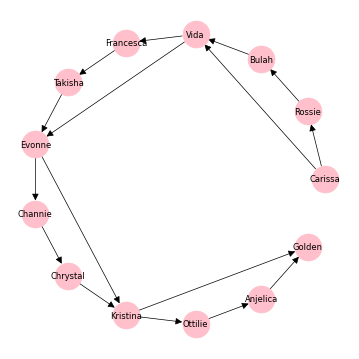


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Carissa will get vaccinated if she had a high fever or bronchitis for at least 4 days in the previous flu season. Rossie will get vaccinated if she had a high fever or bronchitis for at least 7 days in the previous flu season and Carissa gets vaccinated. Bulah will get vaccinated if she had a high fever or bronchitis for at least 6 days in the previous flu season or if Rossie gets vaccinated. Vida will get vaccinated if she had a high fever or bronchitis for at least 5 days in the previous flu season and Carissa gets vaccinated and Bulah gets vaccinated. Francesca will get vaccinated if she had a high fever or bronchitis for at least 7 days in the previous flu season or if Vida gets vaccinated. Takisha will get vaccinated if she had a high fever or bronchitis for at least 5 days in the previous flu season and Francesca gets vaccinated. Evonne will get vaccinated if she had a h

In [21]:
size = [4,4,4,4]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())
print("- Causal functions:", tg.causal_functions)

## Generate dataset

In [27]:
# x levels of graphical complexity (captured by BCC size).
# y tasks per graphical complexity level.
# z samples per task.
# = x*y*z subtasks.
graph_sizes = [[4,4,4]]
n_tasks_per_size = 1
n_samples_per_task = 5000
reps_per_sample = None

df = dg.get_dataset(task_generator = FluVaccine,
                    graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task, 
                    reps_per_sample = reps_per_sample)

display(df)

,Task ID,Context ID,Sample ID,Nodes per BCC,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Exogenous variables,Bernoulli parameters,Global quantity,Local quantities,Compositions,Causal context,Sample context,Factual queries,Interventional queries (cause = True),Interventional queries (cause = False)
0,0.0,0,0,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosha, Attie, Danette, Ami...","[[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0,...","[Trinidad, Attie, Jazmin, Harriet]","[OWE6, JKOY, KFRA, JJ13, EXOD, 6PH9, 18EP, RZW...","[0.5, 0.7, 0.7, 0.5, 0.7, 0.7, 0.7, 0.6, 0.6, ...","(Trinidad, Harriet)","[(Trinidad, Attie), (Trinidad, Jazmin), (Attie...","[[(Trinidad, Attie), (Attie, Jazmin), (Jazmin,...",A group of friends is considering whether or n...,"During the previous flu season, Trinidad had ...",{'Harriet': {'Prompt': 'Did Harriet get vaccin...,"{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup...","{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup..."
1,0.1,0,1,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosha, Attie, Danette, Ami...","[[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0,...","[Trinidad, Attie, Jazmin, Harriet]","[OWE6, JKOY, KFRA, JJ13, EXOD, 6PH9, 18EP, RZW...","[0.5, 0.7, 0.7, 0.5, 0.7, 0.7, 0.7, 0.6, 0.6, ...","(Trinidad, Harriet)","[(Trinidad, Attie), (Trinidad, Jazmin), (Attie...","[[(Trinidad, Attie), (Attie, Jazmin), (Jazmin,...",A group of friends is considering whether or n...,"During the previous flu season, Trinidad had ...",{'Harriet': {'Prompt': 'Did Harriet get vaccin...,"{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup...","{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup..."
2,0.2,0,2,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosha, Attie, Danette, Ami...","[[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0,...","[Trinidad, Attie, Jazmin, Harriet]","[OWE6, JKOY, KFRA, JJ13, EXOD, 6PH9, 18EP, RZW...","[0.5, 0.7, 0.7, 0.5, 0.7, 0.7, 0.7, 0.6, 0.6, ...","(Trinidad, Harriet)","[(Trinidad, Attie), (Trinidad, Jazmin), (Attie...","[[(Trinidad, Attie), (Attie, Jazmin), (Jazmin,...",A group of friends is considering whether or n...,"During the previous flu season, Trinidad had ...",{'Harriet': {'Prompt': 'Did Harriet get vaccin...,"{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup...","{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup..."
3,0.3,0,3,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosha, Attie, Danette, Ami...","[[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0,...","[Trinidad, Attie, Jazmin, Harriet]","[OWE6, JKOY, KFRA, JJ13, EXOD, 6PH9, 18EP, RZW...","[0.5, 0.7, 0.7, 0.5, 0.7, 0.7, 0.7, 0.6, 0.6, ...","(Trinidad, Harriet)","[(Trinidad, Attie), (Trinidad, Jazmin), (Attie...","[[(Trinidad, Attie), (Attie, Jazmin), (Jazmin,...",A group of friends is considering whether or n...,"During the previous flu season, Trinidad had ...",{'Harriet': {'Prompt': 'Did Harriet get vaccin...,"{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup...","{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup..."
4,0.4,0,4,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosha, Attie, Danette, Ami...","[[0, 1, 1, 1], [0, 0, 1, 1], [0, 0, 0, 1], [0,...","[Trinidad, Attie, Jazmin, Harriet]","[OWE6, JKOY, KFRA, JJ13, EXOD, 6PH9, 18EP, RZW...","[0.5, 0.7, 0.7, 0.5, 0.7, 0.7, 0.7, 0.6, 0.6, ...","(Trinidad, Harriet)","[(Trinidad, Attie), (Trinidad, Jazmin), (Attie...","[[(Trinidad, Attie), (Attie, Jazmin), (Jazmin,...",A group of friends is considering whether or n...,"During the previous flu season, Trinidad had ...",{'Harriet': {'Prompt': 'Did Harriet get vaccin...,"{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup...","{('Trinidad', 'Harriet'): {'Prompt': 'Now, sup..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.4995,0,4995,"[4, 4, 4]","[[0, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, ...","[Trinidad, Cheryle, Tosh

In [28]:
# Process prompts.
df_factual, df_cf = dg.process_prompts()
display(df_factual)
display(df_cf)

,Task ID,Context ID,Sample ID,Nodes per BCC,Effect,Context,Question,True
0,0.0,0,0,"[4, 4, 4]",Harriet,A group of friends is considering whether or n...,Did Harriet get vaccinated? Begin your respons...,1
1,0.0,0,0,"[4, 4, 4]",Attie,A group of friends is considering whether or n...,Did Attie get vaccinated? Begin your response ...,0
2,0.0,0,0,"[4, 4, 4]",Jazmin,A group of friends is considering whether or n...,Did Jazmin get vaccinated? Begin your response...,1
3,0.1,0,1,"[4, 4, 4]",Harriet,A group of friends is considering whether or n...,Did Harriet get vaccinated? Begin your respons...,1
4,0.1,0,1,"[4, 4, 4]",Attie,A group of friends is considering whether or n...,Did Attie get vaccinated? Begin your response ...,0
...,...,...,...,...,...,...,...,...
14995,0.4998,0,4998,"[4, 4, 4]",Attie,A group of friends is considering whether or n...,Did Attie get vaccinated? Begin your response ...,0
14996,0.4998,0,4998,"[4, 4, 4]",Jazmin,A group of friends is considering whether or n...,Did Jazmin get vaccinated? Begin your response...,1
14997,0.4999,0,4999,"[4, 4, 4]",Harriet,A group of friends is considering whether or n...,Did Harriet get vaccinated? Begin your respons...,1
14998,0.4999,0,4999,"[4, 4, 4]",Attie,A group of friends is considering whether or n...,Did Attie get vaccinated? Begin your response ...,0


,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
0,0.0,0,0,"[4, 4, 4]","(Trinidad, Harriet)",Trinidad,Harriet,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
1,0.0,0,0,"[4, 4, 4]","(Trinidad, Attie)",Trinidad,Attie,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",0,"Now, suppose that Trinidad did not get vaccina...",0
2,0.0,0,0,"[4, 4, 4]","(Trinidad, Jazmin)",Trinidad,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
3,0.0,0,0,"[4, 4, 4]","(Attie, Jazmin)",Attie,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
4,0.0,0,0,"[4, 4, 4]","(Attie, Harriet)",Attie,Harriet,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.4999,0,4999,"[4, 4, 4]","(Trinidad, Attie)",Trinidad,Attie,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",0
29996,0.4999,0,4999,"[4, 4, 4]","(Trinidad, Jazmin)",Trinidad,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
29997,0.4999,0,4999,"[4, 4, 4]","(Attie, Jazmin)",Attie,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
29998,0.4999,0,4999,"[4, 4, 4]","(Attie, Harriet)",Attie,Harriet,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1


In [29]:
pns_dict = dg.get_pns_dict(verbose = True)
pns_dict

-- PNS = 0.0076 | ATE = 0.007600000000000051 --
-- PNS = 0.2404 | ATE = 0.2404 --
-- PNS = 0.0378 | ATE = 0.037800000000000056 --
-- PNS = 0.1618 | ATE = 0.16180000000000005 --
-- PNS = 0.0298 | ATE = 0.02980000000000005 --
-- PNS = 0.2 | ATE = 0.19999999999999996 --


{0: {"('Trinidad', 'Harriet')": 0.0076,
  "('Trinidad', 'Attie')": 0.2404,
  "('Trinidad', 'Jazmin')": 0.0378,
  "('Attie', 'Jazmin')": 0.1618,
  "('Attie', 'Harriet')": 0.0298,
  "('Jazmin', 'Harriet')": 0.2,
  "[('Trinidad', 'Attie'), ('Attie', 'Jazmin'), ('Jazmin', 'Harriet')]": 0.0077793440000000005,
  "[('Trinidad', 'Attie'), ('Attie', 'Harriet')]": 0.00716392,
  "[('Trinidad', 'Jazmin'), ('Jazmin', 'Harriet')]": 0.007560000000000001}}

In [30]:
threshold_dict = dg.get_internal_consistency_thresholds(multiplier = 1.1)
threshold_dict

{0: {"[('Trinidad', 'Attie'), ('Attie', 'Jazmin'), ('Jazmin', 'Harriet')]": 0.0259576842105264,
  "[('Trinidad', 'Attie'), ('Attie', 'Harriet')]": 0.06311684210526318,
  "[('Trinidad', 'Jazmin'), ('Jazmin', 'Harriet')]": 0.005789473684210416}}

In [31]:
df_cf[df_cf["Context ID"] == 0]

,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Context,Question (cause = True),True (cause = True),Question (cause = False),True (cause = False)
0,0.0,0,0,"[4, 4, 4]","(Trinidad, Harriet)",Trinidad,Harriet,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
1,0.0,0,0,"[4, 4, 4]","(Trinidad, Attie)",Trinidad,Attie,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",0,"Now, suppose that Trinidad did not get vaccina...",0
2,0.0,0,0,"[4, 4, 4]","(Trinidad, Jazmin)",Trinidad,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
3,0.0,0,0,"[4, 4, 4]","(Attie, Jazmin)",Attie,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
4,0.0,0,0,"[4, 4, 4]","(Attie, Harriet)",Attie,Harriet,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.4999,0,4999,"[4, 4, 4]","(Trinidad, Attie)",Trinidad,Attie,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",0
29996,0.4999,0,4999,"[4, 4, 4]","(Trinidad, Jazmin)",Trinidad,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Trinidad got vaccinated rega...",1,"Now, suppose that Trinidad did not get vaccina...",1
29997,0.4999,0,4999,"[4, 4, 4]","(Attie, Jazmin)",Attie,Jazmin,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1
29998,0.4999,0,4999,"[4, 4, 4]","(Attie, Harriet)",Attie,Harriet,A group of friends is considering whether or n...,"Now, suppose that Attie got vaccinated regardl...",1,"Now, suppose that Attie did not get vaccinated...",1


In [33]:
#df.to_csv("flu_vaccine_test.csv", index = False)
#df_factual.to_csv("flu_vaccine_test_factual.csv", index = False)
#df_cf.to_csv("flu_vaccine_test_counterfactual.csv", index = False)

In [1]:
import pandas as pd
from utils import Utils

u = Utils()
df = pd.read_csv("flu_vaccine_test.csv")

In [2]:
adj = u.string_to_array(df["DAG adjacency matrix"][0])
adj

array([[0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [4]:
df["DAG nodes"][0]

"['Trinidad', 'Cheryle', 'Tosha', 'Attie', 'Danette', 'Amira', 'Jazmin', 'Jayda', 'Arly', 'Harriet']"

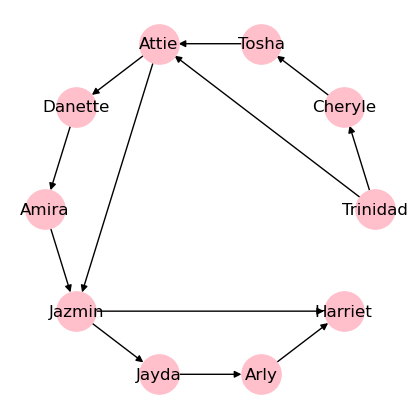

In [6]:
labels = ['Trinidad', 'Cheryle', 'Tosha', 'Attie', 'Danette', 'Amira', 'Jazmin', 'Jayda', 'Arly', 'Harriet']
u.plot_nx(adj, labels = labels, figsize = (4,4), dpi = 100)

## End of document